In [ ]:
! pip install pyspellchecker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.7 MB 5.1 MB/s 


In [ ]:
! python -m spacy download en_core_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 400.7 MB 5.4 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
! pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=af9709849335c47dac2b04df5a77fcbceec573924af82ddf4709d8c4db857c93
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [ ]:
! pip install tomotopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.3 MB 5.3 MB/s 


In [ ]:
# import the package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import re
import seaborn as sns
# import packages
from sklearn.linear_model import LogisticRegression
from spellchecker import SpellChecker
from collections import Counter, OrderedDict
from sklearn.model_selection import train_test_split
import en_core_web_lg
import spacy 
from sklearn.feature_extraction.text import TfidfVectorizer
import pyLDAvis
from tracemalloc import stop
from langcodes import best_match
from matplotlib import rc
import tomotopy as tp
from gensim.models import Phrases


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [ ]:
# load the data
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
# df_submission = pd.read_csv('./submission_file.csv')

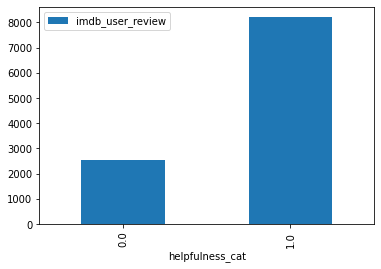

In [ ]:
# check the distribution of the dataset by category
df_train.groupby('helpfulness_cat').count().plot.bar(ylim=0)
plt.show()

In [ ]:
df_test.head()

,_id,imdb_user_review
0,610d01fe9a63eb113d2235ac,This is basically a German takeoff on a Sherlo...
1,610d01fe9a63eb113d224536,"In January of 1924, director Erich von Strohei..."
2,610d01fe9a63eb113d224d14,Silent movies are not for everyone. Neither ar...
3,610d01fe9a63eb113d225f17,It so often happens that some films take the l...
4,610d01fe9a63eb113d225f1a,I saw this film for the very first time last w...


In [ ]:
nlp = spacy.load("en_core_web_lg")

In [ ]:
# separate x and y
review_text = df_train['imdb_user_review']
review_cat = df_train['helpfulness_cat']

### Preprocessing text

In [ ]:
# define a data cleaning function
def clean_data(reviews):
    # # step 1: separate x and y
    # convert review_text df to list
    reviews = reviews.to_list()
    
    # step 2: nromalize the review
    print(f"Total voc number: {len(reviews)}")
    reviews = list(map(lambda x: x.lower(),reviews))

    # step 3: remove Unicode Characters (punctuation, emoji,rul and @) 
    reviews = list(map(lambda x: re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", x),reviews))

    # step 4: remove whitespaces and trailing spaces
    def remove_whitespace(text):
        pattern = re.compile(r'\s+') 
        Without_whitespace = re.sub(pattern, ' ', text)
        text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
        text = text.strip()
        return text
    reviews=list(map(lambda x: remove_whitespace(x),reviews))
                                                                                                                                                                                                                                                                                                    
    # step 5: apply nlp pipeline remove stop words, numbers and lematize the words
    
    # expand the list of stopwords
    gist_file = open("gist_stopwords.txt", "r")
    try:
        content = gist_file.read()
        stopwords = content.split(",")
    finally:
        gist_file.close()
      
    stopwords=[i.replace('"',"").strip() for i in stopwords]
    # add the stopwords to the list of stopwords
    for i in stopwords:
      nlp.Defaults.stop_words.add(i)

    # create colloum for cleaned reviews
    reviews_tokens, tmp_tokens = [], [] 
    for review in tqdm.tqdm(reviews):
        tmp_tokens = [
            token.lemma_
            for token in nlp(review)
            if not token.is_stop 
            and not token.like_num
            and not token.is_punct
            and token.is_alpha
            ]
        reviews_tokens.append(tmp_tokens)
        tmp_tokens=[]
        
    # # convert list back to df 
    # reviews = pd.DataFrame({'imbd_user_review':reviews_tokens})

    return reviews_tokens

In [ ]:
train = clean_data(review_text)

In [ ]:
# create a dataframe for analysis
reviews = pd.DataFrame({'imbd_user_review':train,'helpfulness_cat':review_cat})

In [ ]:
# build spell checker and create spell mistakes
spell = SpellChecker()
mdy_train, temp_train = [], []
for comment in tqdm.tqdm(train):
    temp_train = [word if word in spell else spell.correction(word) for word in comment]
    mdy_train.append(temp_train)
    temp_train=[]
# spell.word_frequency.remove('aka')

In [ ]:
import pickle
file_name='correct_train2.txt'
with open(file_name, "wb") as fp:   #Pickling
    pickle.dump(mdy_train, fp)

In [ ]:
import pickle
with open('correct_train2.txt','rb') as fp:
  mdy_train = pickle.load(fp)

In [ ]:
# remove bracket within the list
tokens_list = [", ".join(token) for token in mdy_train]

## Feature Enginerring

### Word Frequency Analysis

In [ ]:
# explore word frequencies
word_freq = Counter(x for xs in mdy_train_2 for x in set(xs)).most_common()
word_fr = pd.DataFrame(word_freq, columns=['word', 'freq']).sort_values(by='freq', ascending=False)
word_fr


,word,freq
0,watch,3589
1,story,3401
2,time,3383
3,good,3127
4,character,2872
...,...,...
28825,antarctic,1
28824,tugging,1
28823,glaciercovered,1
28822,edifice,1


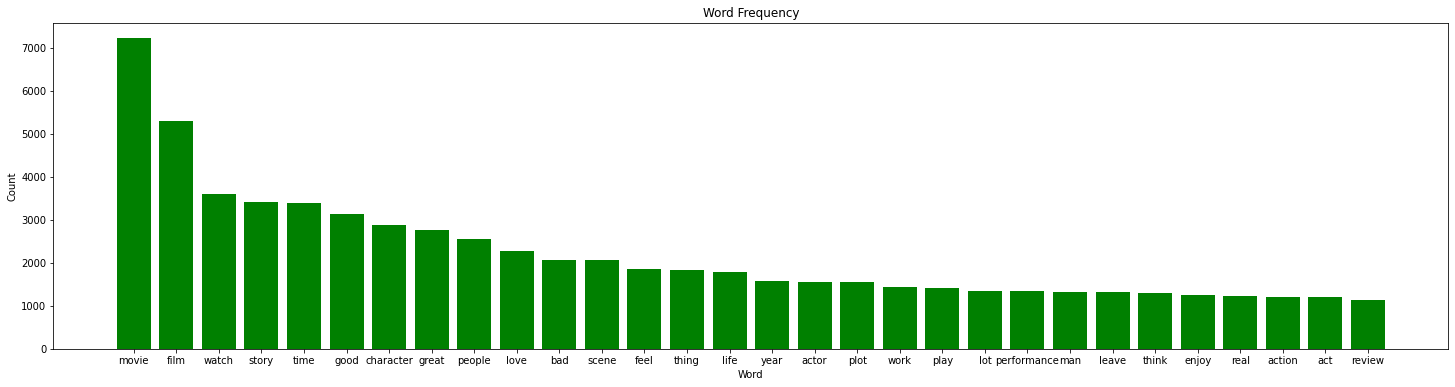

In [ ]:
# visualize word frequencies
# figure size
fig = plt.figure(figsize=(25, 6))
plt.bar(word_fr.word[0:30], word_fr.freq[0:30], color='green')
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Word Frequency")
plt.show()



In [ ]:
# define a data cleaning function
def clean_data(reviews):
    # # step 1: separate x and y
    # convert review_text df to list
    reviews = reviews.to_list()
    
    # step 2: nromalize the review
    print(f"Total voc number: {len(reviews)}")
    reviews = list(map(lambda x: x.lower(),reviews))

    # step 3: remove Unicode Characters (punctuation, emoji,rul and @) 
    reviews = list(map(lambda x: re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", x),reviews))

    # step 4: remove whitespaces and trailing spaces
    def remove_whitespace(text):
        pattern = re.compile(r'\s+') 
        Without_whitespace = re.sub(pattern, ' ', text)
        text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
        text = text.strip()
        return text
    reviews=list(map(lambda x: remove_whitespace(x),reviews))
                                                                                                                                                                                                                                                                                                    
    # step 5: apply nlp pipeline remove stop words, numbers and lematize the words
    
    # expand the list of stopwords
    gist_file = open("gist_stopwords.txt", "r")
    try:
        content = gist_file.read()
        stopwords = content.split(",")
    finally:
        gist_file.close()
      
    stopwords=[i.replace('"',"").strip() for i in stopwords]
    # add the stopwords to the list of stopwords
    for i in stopwords:
      nlp.Defaults.stop_words.add(i)

    # create colloum for cleaned reviews
    tags = ['NOUN','ADJ','VERB','ADV']
    reviews_tokens, tmp_tokens = [], [] 
    for review in tqdm.tqdm(reviews):
        tmp_tokens = [
            token.lemma_
            for token in nlp(review)
            if not token.is_stop 
            and not token.like_num
            and not token.is_punct
            and token.is_alpha
            and token.pos_ in tags 
            ]
        reviews_tokens.append(tmp_tokens)
        tmp_tokens=[]
        
    # # convert list back to df 
    # reviews = pd.DataFrame({'imbd_user_review':reviews_tokens})

    return reviews_tokens

In [ ]:
reviews_tokens_3 = clean_data(review_text)

Total voc number: 10755


100%|██████████| 10755/10755 [04:34<00:00, 39.12it/s]


In [ ]:
len(reviews_tokens_3)

10755

In [ ]:
# remove most frequent words which is known in this context
# word_list=['movie','film']
word_list=['movie','film','good','feel','think','bad','great','watch']
mdy_train_2, tmp=[],[]
for review in reviews_tokens_3:
    for word in review:
        if word not in word_list:
            tmp.append(word)
    mdy_train_2.append(tmp)
    tmp=[]

In [ ]:
# remove bracket within the list
tokens_list = [", ".join(token) for token in mdy_train_2]

### Topic Modeling

In [ ]:
# get rid of common terms
common_terms = [
    u"of",
    u"with",
    u"without",
    u"and",
    u"or",
    u"the",
    u"a",
    u"not",
    "be",
    u"to",
    u"this",
    u"who",
    u"in",
]
## find phrases
# find bigram first
bigram = Phrases(
    mdy_train_2,
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
# find trigram
trigram = Phrases(
    bigram[mdy_train_2],
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)

#option 1
# uncomment if bi-grammed, tokenized document is preferred
docs_phrased = [bigram[line] for line in mdy_train_2]

#option 2
# docs_phrased = [trigram[bigram[line]] for line in mdy_train_2]

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# create a corpus using Tomotopy utils
# empty corpus
corpus = tp.utils.Corpus()
# populate the corpus
for item in docs_phrased:
    corpus.add_doc(words=item)

In [ ]:
# topic modeling ― explore model validity
# register "UMass" coherence scores
cvs = {}
for topic_number in tqdm.tqdm(range(1, 100, 1)):
    mdl = tp.LDAModel(k=topic_number, corpus=corpus)
    for i in range(0, 100, 10):
        mdl.train(10)
        print("Iteration: {}\tLog-likelihood: {}".format(i, mdl.ll_per_word))
    coh = tp.coherence.Coherence(mdl, coherence='u_mass') #c_v
    cvs[topic_number] = coh.get_score()

  0%|          | 0/99 [00:00<?, ?it/s]

Iteration: 0	Log-likelihood: -8.463102245833623
Iteration: 10	Log-likelihood: -8.463102245833623
Iteration: 20	Log-likelihood: -8.463102245833623
Iteration: 30	Log-likelihood: -8.463102245833623
Iteration: 40	Log-likelihood: -8.463102245833623
Iteration: 50	Log-likelihood: -8.463102245833623
Iteration: 60	Log-likelihood: -8.463102245833623
Iteration: 70	Log-likelihood: -8.463102245833623


  1%|          | 1/99 [00:01<02:19,  1.42s/it]

Iteration: 80	Log-likelihood: -8.463102245833623
Iteration: 90	Log-likelihood: -8.463102245833623
Iteration: 0	Log-likelihood: -8.935369867102954
Iteration: 10	Log-likelihood: -8.847137702468265
Iteration: 20	Log-likelihood: -8.745870596022648
Iteration: 30	Log-likelihood: -8.708417105507454
Iteration: 40	Log-likelihood: -8.685873874655085
Iteration: 50	Log-likelihood: -8.67255680096931
Iteration: 60	Log-likelihood: -8.666778200497523


  2%|▏         | 2/99 [00:03<02:29,  1.54s/it]

Iteration: 70	Log-likelihood: -8.66119067758184
Iteration: 80	Log-likelihood: -8.653659358756158
Iteration: 90	Log-likelihood: -8.649404684771321
Iteration: 0	Log-likelihood: -9.170238306828736
Iteration: 10	Log-likelihood: -9.076732094490419
Iteration: 20	Log-likelihood: -8.9272372753895
Iteration: 30	Log-likelihood: -8.850518095404608
Iteration: 40	Log-likelihood: -8.809221512112195
Iteration: 50	Log-likelihood: -8.786953179057898


  3%|▎         | 3/99 [00:04<02:40,  1.67s/it]

Iteration: 60	Log-likelihood: -8.773732619643269
Iteration: 70	Log-likelihood: -8.76318759389888
Iteration: 80	Log-likelihood: -8.757644766384988
Iteration: 90	Log-likelihood: -8.74960668051212
Iteration: 0	Log-likelihood: -9.32237337174052
Iteration: 10	Log-likelihood: -9.185694789185941
Iteration: 20	Log-likelihood: -9.02527675733898
Iteration: 30	Log-likelihood: -8.949969123181363
Iteration: 40	Log-likelihood: -8.909157353224394
Iteration: 50	Log-likelihood: -8.880375673905053
Iteration: 60	Log-likelihood: -8.8669228626711
Iteration: 70	Log-likelihood: -8.855222021504883
Iteration: 80	Log-likelihood: -8.845974204041056
Iteration: 90	Log-likelihood: -8.83857892862593


  4%|▍         | 4/99 [00:06<02:55,  1.85s/it]

Iteration: 0	Log-likelihood: -9.421793759503757
Iteration: 10	Log-likelihood: -9.246719769709086
Iteration: 20	Log-likelihood: -9.111491151736438
Iteration: 30	Log-likelihood: -9.035656030976723
Iteration: 40	Log-likelihood: -8.988248940092886
Iteration: 50	Log-likelihood: -8.956883816372665
Iteration: 60	Log-likelihood: -8.9334583037038
Iteration: 70	Log-likelihood: -8.914888076203923
Iteration: 80	Log-likelihood: -8.901864870530044


  5%|▌         | 5/99 [00:09<03:06,  1.98s/it]

Iteration: 90	Log-likelihood: -8.88994343717681
Iteration: 0	Log-likelihood: -9.50869450013332
Iteration: 10	Log-likelihood: -9.321691546411806
Iteration: 20	Log-likelihood: -9.185457330787457
Iteration: 30	Log-likelihood: -9.105166614440584
Iteration: 40	Log-likelihood: -9.057268780494738
Iteration: 50	Log-likelihood: -9.023446435189646
Iteration: 60	Log-likelihood: -8.995147904751823
Iteration: 70	Log-likelihood: -8.983063576333608
Iteration: 80	Log-likelihood: -8.967320121312659


  6%|▌         | 6/99 [00:11<03:16,  2.11s/it]

Iteration: 90	Log-likelihood: -8.95485757663288
Iteration: 0	Log-likelihood: -9.579759235311421
Iteration: 10	Log-likelihood: -9.396957941483283
Iteration: 20	Log-likelihood: -9.24788799628719
Iteration: 30	Log-likelihood: -9.161200515731501
Iteration: 40	Log-likelihood: -9.107550340423574
Iteration: 50	Log-likelihood: -9.06653545935053
Iteration: 60	Log-likelihood: -9.040759840953966
Iteration: 70	Log-likelihood: -9.021132107778081


  7%|▋         | 7/99 [00:14<03:26,  2.24s/it]

Iteration: 80	Log-likelihood: -9.001679270283992
Iteration: 90	Log-likelihood: -8.991676782231647
Iteration: 0	Log-likelihood: -9.631653784339031
Iteration: 10	Log-likelihood: -9.438364926814883
Iteration: 20	Log-likelihood: -9.272873502705586
Iteration: 30	Log-likelihood: -9.183113210063238
Iteration: 40	Log-likelihood: -9.131755754779796
Iteration: 50	Log-likelihood: -9.092995038346155
Iteration: 60	Log-likelihood: -9.063096684315523
Iteration: 70	Log-likelihood: -9.03984033073108


  8%|▊         | 8/99 [00:16<03:17,  2.17s/it]

Iteration: 80	Log-likelihood: -9.026283216669421
Iteration: 90	Log-likelihood: -9.008584124976421
Iteration: 0	Log-likelihood: -9.671897323890938
Iteration: 10	Log-likelihood: -9.481430851455697
Iteration: 20	Log-likelihood: -9.339568221143349
Iteration: 30	Log-likelihood: -9.23640380056479
Iteration: 40	Log-likelihood: -9.170377280857387
Iteration: 50	Log-likelihood: -9.130519191712954
Iteration: 60	Log-likelihood: -9.101440852601108
Iteration: 70	Log-likelihood: -9.077808493372066


  9%|▉         | 9/99 [00:18<03:17,  2.19s/it]

Iteration: 80	Log-likelihood: -9.060196823635831
Iteration: 90	Log-likelihood: -9.045544098811899
Iteration: 0	Log-likelihood: -9.724753069410117
Iteration: 10	Log-likelihood: -9.531066353402313
Iteration: 20	Log-likelihood: -9.36440541344631
Iteration: 30	Log-likelihood: -9.263194728159403
Iteration: 40	Log-likelihood: -9.205713194216605
Iteration: 50	Log-likelihood: -9.160542197269574
Iteration: 60	Log-likelihood: -9.132734935660613
Iteration: 70	Log-likelihood: -9.110935940030428
Iteration: 80	Log-likelihood: -9.091178781654852
Iteration: 90	Log-likelihood: -9.07650247606666


 10%|█         | 10/99 [00:20<03:19,  2.24s/it]

Iteration: 0	Log-likelihood: -9.746791020262599
Iteration: 10	Log-likelihood: -9.536255568064984
Iteration: 20	Log-likelihood: -9.379174884829279
Iteration: 30	Log-likelihood: -9.287275728517143
Iteration: 40	Log-likelihood: -9.222299267220963
Iteration: 50	Log-likelihood: -9.177729998527612
Iteration: 60	Log-likelihood: -9.145413083871196
Iteration: 70	Log-likelihood: -9.118624928428225
Iteration: 80	Log-likelihood: -9.102581738160337
Iteration: 90	Log-likelihood: -9.084899678150892


 11%|█         | 11/99 [00:23<03:30,  2.40s/it]

Iteration: 0	Log-likelihood: -9.782961101137232
Iteration: 10	Log-likelihood: -9.56045699511168
Iteration: 20	Log-likelihood: -9.398434277377243
Iteration: 30	Log-likelihood: -9.304918508444024
Iteration: 40	Log-likelihood: -9.2465969281956
Iteration: 50	Log-likelihood: -9.207439149787318
Iteration: 60	Log-likelihood: -9.178371303840171
Iteration: 70	Log-likelihood: -9.15605536250329


 12%|█▏        | 12/99 [00:26<03:39,  2.52s/it]

Iteration: 80	Log-likelihood: -9.136717694205258
Iteration: 90	Log-likelihood: -9.120052360018775
Iteration: 0	Log-likelihood: -9.812931515466598
Iteration: 10	Log-likelihood: -9.592954307151498
Iteration: 20	Log-likelihood: -9.435884918893379
Iteration: 30	Log-likelihood: -9.337209611514432
Iteration: 40	Log-likelihood: -9.27015416028276
Iteration: 50	Log-likelihood: -9.224887064888339
Iteration: 60	Log-likelihood: -9.190873177687193
Iteration: 70	Log-likelihood: -9.16211321026896
Iteration: 80	Log-likelihood: -9.138138203241361
Iteration: 90	Log-likelihood: -9.120884060402211


 13%|█▎        | 13/99 [00:29<03:46,  2.64s/it]

Iteration: 0	Log-likelihood: -9.834630300907945
Iteration: 10	Log-likelihood: -9.61074179593526
Iteration: 20	Log-likelihood: -9.459114301957793
Iteration: 30	Log-likelihood: -9.366407385834938
Iteration: 40	Log-likelihood: -9.306201149158781
Iteration: 50	Log-likelihood: -9.261317124957328


 14%|█▍        | 14/99 [00:32<03:58,  2.80s/it]

Iteration: 60	Log-likelihood: -9.225942617061417
Iteration: 70	Log-likelihood: -9.193650183405484
Iteration: 80	Log-likelihood: -9.172873138380673
Iteration: 90	Log-likelihood: -9.155871302924808
Iteration: 0	Log-likelihood: -9.84382542738884
Iteration: 10	Log-likelihood: -9.597187045126834
Iteration: 20	Log-likelihood: -9.450777318620949
Iteration: 30	Log-likelihood: -9.362099070074892
Iteration: 40	Log-likelihood: -9.297763834038156
Iteration: 50	Log-likelihood: -9.249776559642532
Iteration: 60	Log-likelihood: -9.217123535463488
Iteration: 70	Log-likelihood: -9.188609523210257
Iteration: 80	Log-likelihood: -9.164588303501572
Iteration: 90	Log-likelihood: -9.147493656222482


 15%|█▌        | 15/99 [00:35<04:08,  2.96s/it]

Iteration: 0	Log-likelihood: -9.877986894643868
Iteration: 10	Log-likelihood: -9.63811984435046
Iteration: 20	Log-likelihood: -9.492203689850998
Iteration: 30	Log-likelihood: -9.401980830478104
Iteration: 40	Log-likelihood: -9.342948575403682
Iteration: 50	Log-likelihood: -9.306076320679093
Iteration: 60	Log-likelihood: -9.275921038802192
Iteration: 70	Log-likelihood: -9.248896756940713
Iteration: 80	Log-likelihood: -9.222385729491888
Iteration: 90	Log-likelihood: -9.208899259145799


 16%|█▌        | 16/99 [00:38<04:06,  2.98s/it]

Iteration: 0	Log-likelihood: -9.876208369615837
Iteration: 10	Log-likelihood: -9.616052166927895
Iteration: 20	Log-likelihood: -9.467698451854005
Iteration: 30	Log-likelihood: -9.378785914994625
Iteration: 40	Log-likelihood: -9.314521307562643
Iteration: 50	Log-likelihood: -9.27103290075301
Iteration: 60	Log-likelihood: -9.241782343797354
Iteration: 70	Log-likelihood: -9.218753466429
Iteration: 80	Log-likelihood: -9.196553641142296
Iteration: 90	Log-likelihood: -9.176167195113495


 17%|█▋        | 17/99 [00:41<04:06,  3.00s/it]

Iteration: 0	Log-likelihood: -9.911896431111042
Iteration: 10	Log-likelihood: -9.658075784455615
Iteration: 20	Log-likelihood: -9.504210162247006
Iteration: 30	Log-likelihood: -9.410698028243328
Iteration: 40	Log-likelihood: -9.344547400045267
Iteration: 50	Log-likelihood: -9.299126318646941
Iteration: 60	Log-likelihood: -9.258372736366326
Iteration: 70	Log-likelihood: -9.23080119831261
Iteration: 80	Log-likelihood: -9.206828080714919
Iteration: 90	Log-likelihood: -9.182151341533222


 18%|█▊        | 18/99 [00:44<04:07,  3.06s/it]

Iteration: 0	Log-likelihood: -9.930564686488864
Iteration: 10	Log-likelihood: -9.672685041066922
Iteration: 20	Log-likelihood: -9.519187088653933
Iteration: 30	Log-likelihood: -9.433011673603614
Iteration: 40	Log-likelihood: -9.37045876128336
Iteration: 50	Log-likelihood: -9.327328294257153
Iteration: 60	Log-likelihood: -9.291393335618752
Iteration: 70	Log-likelihood: -9.25342271412746
Iteration: 80	Log-likelihood: -9.232484464105404
Iteration: 90	Log-likelihood: -9.210374352713044


 19%|█▉        | 19/99 [00:48<04:18,  3.23s/it]

Iteration: 0	Log-likelihood: -9.951982573732591
Iteration: 10	Log-likelihood: -9.696247546233419
Iteration: 20	Log-likelihood: -9.536831485765404
Iteration: 30	Log-likelihood: -9.43932148198368
Iteration: 40	Log-likelihood: -9.37067677176459
Iteration: 50	Log-likelihood: -9.322074051979913
Iteration: 60	Log-likelihood: -9.284638243847233
Iteration: 70	Log-likelihood: -9.250775821445332
Iteration: 80	Log-likelihood: -9.230766328526242
Iteration: 90	Log-likelihood: -9.21010593008699


 20%|██        | 20/99 [00:52<04:30,  3.42s/it]

Iteration: 0	Log-likelihood: -9.952440994190512
Iteration: 10	Log-likelihood: -9.68689067664016
Iteration: 20	Log-likelihood: -9.53840369181013
Iteration: 30	Log-likelihood: -9.437201980608965
Iteration: 40	Log-likelihood: -9.366159403371428
Iteration: 50	Log-likelihood: -9.313036596415694
Iteration: 60	Log-likelihood: -9.269164949754348
Iteration: 70	Log-likelihood: -9.237804223283783
Iteration: 80	Log-likelihood: -9.208230758845989
Iteration: 90	Log-likelihood: -9.18992026905562


 21%|██        | 21/99 [00:56<04:36,  3.55s/it]

Iteration: 0	Log-likelihood: -9.963201910727408
Iteration: 10	Log-likelihood: -9.704413786090486
Iteration: 20	Log-likelihood: -9.545199793690733
Iteration: 30	Log-likelihood: -9.446517422932569
Iteration: 40	Log-likelihood: -9.381368949983356
Iteration: 50	Log-likelihood: -9.334096384876647
Iteration: 60	Log-likelihood: -9.294647673070838
Iteration: 70	Log-likelihood: -9.258251058594801
Iteration: 80	Log-likelihood: -9.232263444429902
Iteration: 90	Log-likelihood: -9.20526657920989


 22%|██▏       | 22/99 [01:00<04:41,  3.65s/it]

Iteration: 0	Log-likelihood: -9.974340851481207
Iteration: 10	Log-likelihood: -9.70469327739586
Iteration: 20	Log-likelihood: -9.556488572768743
Iteration: 30	Log-likelihood: -9.46143702967134
Iteration: 40	Log-likelihood: -9.401553081212311
Iteration: 50	Log-likelihood: -9.351909970745973
Iteration: 60	Log-likelihood: -9.31623346570696
Iteration: 70	Log-likelihood: -9.285165504764366
Iteration: 80	Log-likelihood: -9.254019857327464
Iteration: 90	Log-likelihood: -9.236653075603122


 23%|██▎       | 23/99 [01:04<04:48,  3.80s/it]

Iteration: 0	Log-likelihood: -10.006706358326488
Iteration: 10	Log-likelihood: -9.748914608857467
Iteration: 20	Log-likelihood: -9.584392201756625
Iteration: 30	Log-likelihood: -9.482946446256296
Iteration: 40	Log-likelihood: -9.414317485447334
Iteration: 50	Log-likelihood: -9.36060712640399
Iteration: 60	Log-likelihood: -9.323797827633166
Iteration: 70	Log-likelihood: -9.28713408687727
Iteration: 80	Log-likelihood: -9.25410660493116
Iteration: 90	Log-likelihood: -9.234417854203176


 24%|██▍       | 24/99 [01:08<04:44,  3.79s/it]

Iteration: 0	Log-likelihood: -9.986074101828095
Iteration: 10	Log-likelihood: -9.71230811425208
Iteration: 20	Log-likelihood: -9.565838185039867
Iteration: 30	Log-likelihood: -9.477721555505195
Iteration: 40	Log-likelihood: -9.418614481663017
Iteration: 50	Log-likelihood: -9.365092414916862
Iteration: 60	Log-likelihood: -9.322755689770549
Iteration: 70	Log-likelihood: -9.295964408049038
Iteration: 80	Log-likelihood: -9.270582416344086
Iteration: 90	Log-likelihood: -9.247533665541647


 25%|██▌       | 25/99 [01:12<04:45,  3.86s/it]

Iteration: 0	Log-likelihood: -10.013274306063131
Iteration: 10	Log-likelihood: -9.749041050785332
Iteration: 20	Log-likelihood: -9.588554609189217
Iteration: 30	Log-likelihood: -9.494350168503926
Iteration: 40	Log-likelihood: -9.429744140962146
Iteration: 50	Log-likelihood: -9.376928854032018
Iteration: 60	Log-likelihood: -9.331388356021264
Iteration: 70	Log-likelihood: -9.297293013611037
Iteration: 80	Log-likelihood: -9.271160431930161
Iteration: 90	Log-likelihood: -9.2479665034954


 26%|██▋       | 26/99 [01:16<04:52,  4.01s/it]

Iteration: 0	Log-likelihood: -10.038821081078778
Iteration: 10	Log-likelihood: -9.764647807375763
Iteration: 20	Log-likelihood: -9.609040021030987
Iteration: 30	Log-likelihood: -9.51184075839195
Iteration: 40	Log-likelihood: -9.443409748853828
Iteration: 50	Log-likelihood: -9.387654198043174
Iteration: 60	Log-likelihood: -9.348968645401465
Iteration: 70	Log-likelihood: -9.312848620902377
Iteration: 80	Log-likelihood: -9.285601095202592
Iteration: 90	Log-likelihood: -9.26445186916274


 27%|██▋       | 27/99 [01:20<04:58,  4.15s/it]

Iteration: 0	Log-likelihood: -10.031983870138058
Iteration: 10	Log-likelihood: -9.751176719764066
Iteration: 20	Log-likelihood: -9.603335601736076
Iteration: 30	Log-likelihood: -9.51479211992754
Iteration: 40	Log-likelihood: -9.448219573414828
Iteration: 50	Log-likelihood: -9.399778283150017
Iteration: 60	Log-likelihood: -9.357791368968918
Iteration: 70	Log-likelihood: -9.321852643351306
Iteration: 80	Log-likelihood: -9.294325569060078
Iteration: 90	Log-likelihood: -9.267536915730568


 28%|██▊       | 28/99 [01:26<05:30,  4.65s/it]

Iteration: 0	Log-likelihood: -10.050243015066401
Iteration: 10	Log-likelihood: -9.775562883808758
Iteration: 20	Log-likelihood: -9.6277977003511
Iteration: 30	Log-likelihood: -9.529346225804698
Iteration: 40	Log-likelihood: -9.462808593519549
Iteration: 50	Log-likelihood: -9.413206508318243
Iteration: 60	Log-likelihood: -9.36598556001915
Iteration: 70	Log-likelihood: -9.333616798170608
Iteration: 80	Log-likelihood: -9.307833845392723
Iteration: 90	Log-likelihood: -9.280446148807885


 29%|██▉       | 29/99 [01:32<05:45,  4.94s/it]

Iteration: 0	Log-likelihood: -10.059469340395191
Iteration: 10	Log-likelihood: -9.786765181998033
Iteration: 20	Log-likelihood: -9.632017919753796
Iteration: 30	Log-likelihood: -9.539202504660803
Iteration: 40	Log-likelihood: -9.473383767458671
Iteration: 50	Log-likelihood: -9.424983645700358
Iteration: 60	Log-likelihood: -9.381766601136041
Iteration: 70	Log-likelihood: -9.349633251708175
Iteration: 80	Log-likelihood: -9.315842845637425
Iteration: 90	Log-likelihood: -9.295222126966992


 30%|███       | 30/99 [01:37<05:49,  5.06s/it]

Iteration: 0	Log-likelihood: -10.060991693529658
Iteration: 10	Log-likelihood: -9.771871957886017
Iteration: 20	Log-likelihood: -9.631600716722057
Iteration: 30	Log-likelihood: -9.539695330104589
Iteration: 40	Log-likelihood: -9.472459618373192
Iteration: 50	Log-likelihood: -9.425522127061194
Iteration: 60	Log-likelihood: -9.393155380890716
Iteration: 70	Log-likelihood: -9.3615840521765
Iteration: 80	Log-likelihood: -9.333730453105904
Iteration: 90	Log-likelihood: -9.313444740924163


 31%|███▏      | 31/99 [01:43<05:51,  5.17s/it]

Iteration: 0	Log-likelihood: -10.085290957744164
Iteration: 10	Log-likelihood: -9.799316426060752
Iteration: 20	Log-likelihood: -9.639606829731354
Iteration: 30	Log-likelihood: -9.53712715965558
Iteration: 40	Log-likelihood: -9.472003656501213
Iteration: 50	Log-likelihood: -9.425731134255248
Iteration: 60	Log-likelihood: -9.380854803569058
Iteration: 70	Log-likelihood: -9.347896080440657
Iteration: 80	Log-likelihood: -9.320481655129537
Iteration: 90	Log-likelihood: -9.296325227601876


 32%|███▏      | 32/99 [01:48<05:55,  5.31s/it]

Iteration: 0	Log-likelihood: -10.074614299412769
Iteration: 10	Log-likelihood: -9.786278964445762
Iteration: 20	Log-likelihood: -9.637947909827423
Iteration: 30	Log-likelihood: -9.551547292511744
Iteration: 40	Log-likelihood: -9.48432378461889
Iteration: 50	Log-likelihood: -9.435423618308553
Iteration: 60	Log-likelihood: -9.402203167932223
Iteration: 70	Log-likelihood: -9.371001211673219
Iteration: 80	Log-likelihood: -9.347495055025881
Iteration: 90	Log-likelihood: -9.323212765561182


 33%|███▎      | 33/99 [01:54<05:52,  5.35s/it]

Iteration: 0	Log-likelihood: -10.094639229319633
Iteration: 10	Log-likelihood: -9.805292317027474
Iteration: 20	Log-likelihood: -9.648954795188528
Iteration: 30	Log-likelihood: -9.548826184458127
Iteration: 40	Log-likelihood: -9.48083520014775
Iteration: 50	Log-likelihood: -9.431523762951164
Iteration: 60	Log-likelihood: -9.387476239752512
Iteration: 70	Log-likelihood: -9.354645448353269
Iteration: 80	Log-likelihood: -9.325318083589115
Iteration: 90	Log-likelihood: -9.301965120401194


 34%|███▍      | 34/99 [02:00<06:03,  5.59s/it]

Iteration: 0	Log-likelihood: -10.09813821727177
Iteration: 10	Log-likelihood: -9.792923194765788
Iteration: 20	Log-likelihood: -9.637215972596078
Iteration: 30	Log-likelihood: -9.541592702681198
Iteration: 40	Log-likelihood: -9.485868804159145
Iteration: 50	Log-likelihood: -9.433577424233986
Iteration: 60	Log-likelihood: -9.396256440038115
Iteration: 70	Log-likelihood: -9.3692652666463
Iteration: 80	Log-likelihood: -9.341212203404446
Iteration: 90	Log-likelihood: -9.318864833319042


 35%|███▌      | 35/99 [02:06<06:05,  5.71s/it]

Iteration: 0	Log-likelihood: -10.120911221059655
Iteration: 10	Log-likelihood: -9.833546574335342
Iteration: 20	Log-likelihood: -9.679124544836158
Iteration: 30	Log-likelihood: -9.578680917289491
Iteration: 40	Log-likelihood: -9.512935572689955
Iteration: 50	Log-likelihood: -9.458950045452996
Iteration: 60	Log-likelihood: -9.415316621782685
Iteration: 70	Log-likelihood: -9.376922358129958
Iteration: 80	Log-likelihood: -9.345418471068578
Iteration: 90	Log-likelihood: -9.31701679864514


 36%|███▋      | 36/99 [02:12<06:09,  5.87s/it]

Iteration: 0	Log-likelihood: -10.11839536047931
Iteration: 10	Log-likelihood: -9.812271503620444
Iteration: 20	Log-likelihood: -9.657889515904854
Iteration: 30	Log-likelihood: -9.568237202168282
Iteration: 40	Log-likelihood: -9.502887469754203
Iteration: 50	Log-likelihood: -9.45123371759266
Iteration: 60	Log-likelihood: -9.414370537047919
Iteration: 70	Log-likelihood: -9.38225426599461
Iteration: 80	Log-likelihood: -9.353664449033914
Iteration: 90	Log-likelihood: -9.330264224780553


 37%|███▋      | 37/99 [02:18<06:12,  6.01s/it]

Iteration: 0	Log-likelihood: -10.135215639009356
Iteration: 10	Log-likelihood: -9.843566551199707
Iteration: 20	Log-likelihood: -9.687590868542522
Iteration: 30	Log-likelihood: -9.591131364669627
Iteration: 40	Log-likelihood: -9.522018149646208
Iteration: 50	Log-likelihood: -9.463789814888816
Iteration: 60	Log-likelihood: -9.417608872486783
Iteration: 70	Log-likelihood: -9.378257775771804
Iteration: 80	Log-likelihood: -9.342200572704387
Iteration: 90	Log-likelihood: -9.311896704483917


 38%|███▊      | 38/99 [02:25<06:14,  6.14s/it]

Iteration: 0	Log-likelihood: -10.133963963823707
Iteration: 10	Log-likelihood: -9.843108946464435
Iteration: 20	Log-likelihood: -9.689372744819659
Iteration: 30	Log-likelihood: -9.600144846816484
Iteration: 40	Log-likelihood: -9.532090588068069
Iteration: 50	Log-likelihood: -9.479340077103679
Iteration: 60	Log-likelihood: -9.43848840552117
Iteration: 70	Log-likelihood: -9.40322861595783
Iteration: 80	Log-likelihood: -9.37919447273014
Iteration: 90	Log-likelihood: -9.355693875860549


 39%|███▉      | 39/99 [02:32<06:23,  6.39s/it]

Iteration: 0	Log-likelihood: -10.14409646943254
Iteration: 10	Log-likelihood: -9.83590629756738
Iteration: 20	Log-likelihood: -9.684517272167193
Iteration: 30	Log-likelihood: -9.58487100024796
Iteration: 40	Log-likelihood: -9.51930631111418
Iteration: 50	Log-likelihood: -9.465226164010076
Iteration: 60	Log-likelihood: -9.421100676847567
Iteration: 70	Log-likelihood: -9.388604472053455
Iteration: 80	Log-likelihood: -9.359884894507118
Iteration: 90	Log-likelihood: -9.338493998527147


 40%|████      | 40/99 [02:38<06:21,  6.47s/it]

Iteration: 0	Log-likelihood: -10.147550605122605
Iteration: 10	Log-likelihood: -9.84688374356184
Iteration: 20	Log-likelihood: -9.692751684542582
Iteration: 30	Log-likelihood: -9.597726663642385
Iteration: 40	Log-likelihood: -9.530588785751558
Iteration: 50	Log-likelihood: -9.479599250712145
Iteration: 60	Log-likelihood: -9.433555413096318
Iteration: 70	Log-likelihood: -9.402406771453421
Iteration: 80	Log-likelihood: -9.369968480458505
Iteration: 90	Log-likelihood: -9.339860668064144


 41%|████▏     | 41/99 [02:46<06:37,  6.86s/it]

Iteration: 0	Log-likelihood: -10.164707649909882
Iteration: 10	Log-likelihood: -9.85624144974482
Iteration: 20	Log-likelihood: -9.694951771860682
Iteration: 30	Log-likelihood: -9.601186643808148
Iteration: 40	Log-likelihood: -9.534913674404129
Iteration: 50	Log-likelihood: -9.488138568918055
Iteration: 60	Log-likelihood: -9.448152559024146
Iteration: 70	Log-likelihood: -9.41296369211445
Iteration: 80	Log-likelihood: -9.382295297458255
Iteration: 90	Log-likelihood: -9.359117749952189


 42%|████▏     | 42/99 [02:54<06:41,  7.04s/it]

Iteration: 0	Log-likelihood: -10.157210871240292
Iteration: 10	Log-likelihood: -9.83529541749429
Iteration: 20	Log-likelihood: -9.686384020213378
Iteration: 30	Log-likelihood: -9.590489524159262
Iteration: 40	Log-likelihood: -9.528288330863102
Iteration: 50	Log-likelihood: -9.478792662482778
Iteration: 60	Log-likelihood: -9.435851816416056
Iteration: 70	Log-likelihood: -9.399059774064813
Iteration: 80	Log-likelihood: -9.366750471725723
Iteration: 90	Log-likelihood: -9.333881354717048


 43%|████▎     | 43/99 [03:02<06:47,  7.27s/it]

Iteration: 0	Log-likelihood: -10.173395719267898
Iteration: 10	Log-likelihood: -9.87161216817137
Iteration: 20	Log-likelihood: -9.710760919202013
Iteration: 30	Log-likelihood: -9.611358468193709
Iteration: 40	Log-likelihood: -9.551737078415197
Iteration: 50	Log-likelihood: -9.497400971687417
Iteration: 60	Log-likelihood: -9.459622115995138
Iteration: 70	Log-likelihood: -9.422758297682774
Iteration: 80	Log-likelihood: -9.3909540788512
Iteration: 90	Log-likelihood: -9.364043116858447


 44%|████▍     | 44/99 [03:10<06:58,  7.62s/it]

Iteration: 0	Log-likelihood: -10.183042012769137
Iteration: 10	Log-likelihood: -9.87767873404536
Iteration: 20	Log-likelihood: -9.716945659208314
Iteration: 30	Log-likelihood: -9.623181301357217
Iteration: 40	Log-likelihood: -9.551542223476176
Iteration: 50	Log-likelihood: -9.502619477969981
Iteration: 60	Log-likelihood: -9.466945645074086
Iteration: 70	Log-likelihood: -9.436128078260369
Iteration: 80	Log-likelihood: -9.407117423405698
Iteration: 90	Log-likelihood: -9.379488149195696


 45%|████▌     | 45/99 [03:19<07:19,  8.14s/it]

Iteration: 0	Log-likelihood: -10.189302567153426
Iteration: 10	Log-likelihood: -9.878902061537406
Iteration: 20	Log-likelihood: -9.725645825118086
Iteration: 30	Log-likelihood: -9.629752990454907
Iteration: 40	Log-likelihood: -9.562993640556739
Iteration: 50	Log-likelihood: -9.510766610394729
Iteration: 60	Log-likelihood: -9.470777450990727
Iteration: 70	Log-likelihood: -9.432887531295274
Iteration: 80	Log-likelihood: -9.39907293015199
Iteration: 90	Log-likelihood: -9.37359259161612


 46%|████▋     | 46/99 [03:28<07:20,  8.30s/it]

Iteration: 0	Log-likelihood: -10.192541598909377
Iteration: 10	Log-likelihood: -9.886963701786902
Iteration: 20	Log-likelihood: -9.722188155117175
Iteration: 30	Log-likelihood: -9.625839811885173
Iteration: 40	Log-likelihood: -9.559447553910335
Iteration: 50	Log-likelihood: -9.50142138194974
Iteration: 60	Log-likelihood: -9.458495072572545
Iteration: 70	Log-likelihood: -9.42768508316844
Iteration: 80	Log-likelihood: -9.392443366941473
Iteration: 90	Log-likelihood: -9.365081399931237


 47%|████▋     | 47/99 [03:37<07:17,  8.40s/it]

Iteration: 0	Log-likelihood: -10.18933186419482
Iteration: 10	Log-likelihood: -9.874227405195848
Iteration: 20	Log-likelihood: -9.718071993621855
Iteration: 30	Log-likelihood: -9.617886263470549
Iteration: 40	Log-likelihood: -9.546258402481644
Iteration: 50	Log-likelihood: -9.494926811157052
Iteration: 60	Log-likelihood: -9.45252535335696
Iteration: 70	Log-likelihood: -9.414522950057894
Iteration: 80	Log-likelihood: -9.38404006473075
Iteration: 90	Log-likelihood: -9.358459209372008


 48%|████▊     | 48/99 [03:46<07:19,  8.62s/it]

Iteration: 0	Log-likelihood: -10.200813369143637
Iteration: 10	Log-likelihood: -9.88566012081217
Iteration: 20	Log-likelihood: -9.722952837620946
Iteration: 30	Log-likelihood: -9.626005839797223
Iteration: 40	Log-likelihood: -9.55635081836928
Iteration: 50	Log-likelihood: -9.50805796942247
Iteration: 60	Log-likelihood: -9.464352030074116
Iteration: 70	Log-likelihood: -9.430722000775006
Iteration: 80	Log-likelihood: -9.400689233134303
Iteration: 90	Log-likelihood: -9.372938051070326


 49%|████▉     | 49/99 [03:56<07:30,  9.02s/it]

Iteration: 0	Log-likelihood: -10.21070220999705
Iteration: 10	Log-likelihood: -9.890510433602003
Iteration: 20	Log-likelihood: -9.731196317290266
Iteration: 30	Log-likelihood: -9.63670132421569
Iteration: 40	Log-likelihood: -9.567686236359783
Iteration: 50	Log-likelihood: -9.515335003908037
Iteration: 60	Log-likelihood: -9.476122372046941
Iteration: 70	Log-likelihood: -9.441147379269664
Iteration: 80	Log-likelihood: -9.408102117102308
Iteration: 90	Log-likelihood: -9.386329839195609


 51%|█████     | 50/99 [04:05<07:22,  9.04s/it]

Iteration: 0	Log-likelihood: -10.220216062619835
Iteration: 10	Log-likelihood: -9.90368010869842
Iteration: 20	Log-likelihood: -9.745251162849828
Iteration: 30	Log-likelihood: -9.646797022945039
Iteration: 40	Log-likelihood: -9.576037592056105
Iteration: 50	Log-likelihood: -9.522966943027603
Iteration: 60	Log-likelihood: -9.476768879290436
Iteration: 70	Log-likelihood: -9.439229602736466
Iteration: 80	Log-likelihood: -9.411604002377816
Iteration: 90	Log-likelihood: -9.383022305999447


 52%|█████▏    | 51/99 [04:15<07:34,  9.48s/it]

Iteration: 0	Log-likelihood: -10.223722453634858
Iteration: 10	Log-likelihood: -9.916210308693712
Iteration: 20	Log-likelihood: -9.749104501561982
Iteration: 30	Log-likelihood: -9.647232436746116
Iteration: 40	Log-likelihood: -9.571377817757666
Iteration: 50	Log-likelihood: -9.517190326906881
Iteration: 60	Log-likelihood: -9.47053293836554
Iteration: 70	Log-likelihood: -9.429415724820533
Iteration: 80	Log-likelihood: -9.398545832115472
Iteration: 90	Log-likelihood: -9.36373567047646


 53%|█████▎    | 52/99 [04:26<07:42,  9.84s/it]

Iteration: 0	Log-likelihood: -10.236395688554484
Iteration: 10	Log-likelihood: -9.910562278699022
Iteration: 20	Log-likelihood: -9.744572730147405
Iteration: 30	Log-likelihood: -9.651528143791086
Iteration: 40	Log-likelihood: -9.578837652166968
Iteration: 50	Log-likelihood: -9.526916865121834
Iteration: 60	Log-likelihood: -9.483392553003798
Iteration: 70	Log-likelihood: -9.445411512850063
Iteration: 80	Log-likelihood: -9.413300692325867
Iteration: 90	Log-likelihood: -9.383724861032436


 54%|█████▎    | 53/99 [04:37<07:55, 10.34s/it]

Iteration: 0	Log-likelihood: -10.24435451836094
Iteration: 10	Log-likelihood: -9.926093163822028
Iteration: 20	Log-likelihood: -9.769189914424032
Iteration: 30	Log-likelihood: -9.670466833253235
Iteration: 40	Log-likelihood: -9.599562195887316
Iteration: 50	Log-likelihood: -9.548991126190495
Iteration: 60	Log-likelihood: -9.503581366423177
Iteration: 70	Log-likelihood: -9.471970343432591
Iteration: 80	Log-likelihood: -9.441162889552
Iteration: 90	Log-likelihood: -9.414500911433391


 55%|█████▍    | 54/99 [04:50<08:09, 10.87s/it]

Iteration: 0	Log-likelihood: -10.246769513149838
Iteration: 10	Log-likelihood: -9.931173959920535
Iteration: 20	Log-likelihood: -9.775485677843855
Iteration: 30	Log-likelihood: -9.676183441807021
Iteration: 40	Log-likelihood: -9.612442566168502
Iteration: 50	Log-likelihood: -9.559445980879367
Iteration: 60	Log-likelihood: -9.515393146853922
Iteration: 70	Log-likelihood: -9.472614103570745
Iteration: 80	Log-likelihood: -9.438866075984606
Iteration: 90	Log-likelihood: -9.407783997629414


 56%|█████▌    | 55/99 [05:01<08:03, 10.98s/it]

Iteration: 0	Log-likelihood: -10.252873502723688
Iteration: 10	Log-likelihood: -9.93190021741271
Iteration: 20	Log-likelihood: -9.769071147663851
Iteration: 30	Log-likelihood: -9.676221922945754
Iteration: 40	Log-likelihood: -9.606511758863824
Iteration: 50	Log-likelihood: -9.555809296187316
Iteration: 60	Log-likelihood: -9.510831664106124
Iteration: 70	Log-likelihood: -9.467654241869289
Iteration: 80	Log-likelihood: -9.438977945204108
Iteration: 90	Log-likelihood: -9.409234728028514


 57%|█████▋    | 56/99 [05:13<08:02, 11.22s/it]

Iteration: 0	Log-likelihood: -10.244052021045576
Iteration: 10	Log-likelihood: -9.925681093586615
Iteration: 20	Log-likelihood: -9.767410805519866
Iteration: 30	Log-likelihood: -9.672759894165951
Iteration: 40	Log-likelihood: -9.60350614265454
Iteration: 50	Log-likelihood: -9.549548882581789
Iteration: 60	Log-likelihood: -9.507965127177817
Iteration: 70	Log-likelihood: -9.466739994807684
Iteration: 80	Log-likelihood: -9.435334628900694
Iteration: 90	Log-likelihood: -9.401755991656323


 58%|█████▊    | 57/99 [05:25<08:01, 11.47s/it]

Iteration: 0	Log-likelihood: -10.266958480561904
Iteration: 10	Log-likelihood: -9.940274209052758
Iteration: 20	Log-likelihood: -9.783239336463751
Iteration: 30	Log-likelihood: -9.688245370554798
Iteration: 40	Log-likelihood: -9.614568566483426
Iteration: 50	Log-likelihood: -9.559659498681386
Iteration: 60	Log-likelihood: -9.511955020943184
Iteration: 70	Log-likelihood: -9.466894314870855
Iteration: 80	Log-likelihood: -9.43205992797804
Iteration: 90	Log-likelihood: -9.402167681460979


 59%|█████▊    | 58/99 [05:36<07:52, 11.54s/it]

Iteration: 0	Log-likelihood: -10.257320621971182
Iteration: 10	Log-likelihood: -9.92957457472351
Iteration: 20	Log-likelihood: -9.770548612079311
Iteration: 30	Log-likelihood: -9.665191194295911
Iteration: 40	Log-likelihood: -9.594941900127166
Iteration: 50	Log-likelihood: -9.54538007592812
Iteration: 60	Log-likelihood: -9.508087370991811
Iteration: 70	Log-likelihood: -9.46862143212447
Iteration: 80	Log-likelihood: -9.438496341773819
Iteration: 90	Log-likelihood: -9.409806731465688


 60%|█████▉    | 59/99 [05:48<07:45, 11.65s/it]

Iteration: 0	Log-likelihood: -10.27164974912078
Iteration: 10	Log-likelihood: -9.939751768290183
Iteration: 20	Log-likelihood: -9.774221868646315
Iteration: 30	Log-likelihood: -9.680526354011294
Iteration: 40	Log-likelihood: -9.61569465141651
Iteration: 50	Log-likelihood: -9.558926502182043
Iteration: 60	Log-likelihood: -9.51763427227858
Iteration: 70	Log-likelihood: -9.475156197489486
Iteration: 80	Log-likelihood: -9.444620551772845
Iteration: 90	Log-likelihood: -9.41205404598364


 61%|██████    | 60/99 [06:01<07:45, 11.94s/it]

Iteration: 0	Log-likelihood: -10.27621072555699
Iteration: 10	Log-likelihood: -9.944305143632947
Iteration: 20	Log-likelihood: -9.782675263372372
Iteration: 30	Log-likelihood: -9.68215897420908
Iteration: 40	Log-likelihood: -9.610317514187837
Iteration: 50	Log-likelihood: -9.550622118015472
Iteration: 60	Log-likelihood: -9.499452120264614
Iteration: 70	Log-likelihood: -9.456910635916733
Iteration: 80	Log-likelihood: -9.41601015845221
Iteration: 90	Log-likelihood: -9.386841517679667


 62%|██████▏   | 61/99 [06:15<07:52, 12.45s/it]

Iteration: 0	Log-likelihood: -10.279146231124095
Iteration: 10	Log-likelihood: -9.947892559756983
Iteration: 20	Log-likelihood: -9.79561373667261
Iteration: 30	Log-likelihood: -9.703913437138644
Iteration: 40	Log-likelihood: -9.63745151014257
Iteration: 50	Log-likelihood: -9.580821774840008
Iteration: 60	Log-likelihood: -9.539160270403173
Iteration: 70	Log-likelihood: -9.503216804755203
Iteration: 80	Log-likelihood: -9.468966135754656
Iteration: 90	Log-likelihood: -9.438014981509095


 63%|██████▎   | 62/99 [06:27<07:45, 12.58s/it]

Iteration: 0	Log-likelihood: -10.289749911588581
Iteration: 10	Log-likelihood: -9.953072321296421
Iteration: 20	Log-likelihood: -9.7875858724266
Iteration: 30	Log-likelihood: -9.691108302182684
Iteration: 40	Log-likelihood: -9.620854783560434
Iteration: 50	Log-likelihood: -9.563371353337587
Iteration: 60	Log-likelihood: -9.517972854062402
Iteration: 70	Log-likelihood: -9.47571279807995
Iteration: 80	Log-likelihood: -9.44115258729726
Iteration: 90	Log-likelihood: -9.411951601366138


 64%|██████▎   | 63/99 [06:40<07:38, 12.73s/it]

Iteration: 0	Log-likelihood: -10.291651564229632
Iteration: 10	Log-likelihood: -9.964613671927323
Iteration: 20	Log-likelihood: -9.803309413991004
Iteration: 30	Log-likelihood: -9.703342442123525
Iteration: 40	Log-likelihood: -9.638902658703831
Iteration: 50	Log-likelihood: -9.587765393090233
Iteration: 60	Log-likelihood: -9.538265811373364
Iteration: 70	Log-likelihood: -9.503358477818296
Iteration: 80	Log-likelihood: -9.470757776243536
Iteration: 90	Log-likelihood: -9.443187469340515


 65%|██████▍   | 64/99 [06:56<07:54, 13.56s/it]

Iteration: 0	Log-likelihood: -10.304518692031591
Iteration: 10	Log-likelihood: -9.973974158487472
Iteration: 20	Log-likelihood: -9.807796843620446
Iteration: 30	Log-likelihood: -9.70982999034121
Iteration: 40	Log-likelihood: -9.637464730405473
Iteration: 50	Log-likelihood: -9.579324756687628
Iteration: 60	Log-likelihood: -9.537650220864068
Iteration: 70	Log-likelihood: -9.501239261667402
Iteration: 80	Log-likelihood: -9.470989224122173
Iteration: 90	Log-likelihood: -9.439988737528443


 66%|██████▌   | 65/99 [07:09<07:32, 13.32s/it]

Iteration: 0	Log-likelihood: -10.30542030655651
Iteration: 10	Log-likelihood: -9.980172362745574
Iteration: 20	Log-likelihood: -9.810104731079289
Iteration: 30	Log-likelihood: -9.715638183226872
Iteration: 40	Log-likelihood: -9.646003384425802
Iteration: 50	Log-likelihood: -9.590714643524855
Iteration: 60	Log-likelihood: -9.544461262838341
Iteration: 70	Log-likelihood: -9.507841587284908
Iteration: 80	Log-likelihood: -9.469304255990378
Iteration: 90	Log-likelihood: -9.439832383478308


 67%|██████▋   | 66/99 [07:23<07:28, 13.60s/it]

Iteration: 0	Log-likelihood: -10.306141938553028
Iteration: 10	Log-likelihood: -9.97330924346865
Iteration: 20	Log-likelihood: -9.812132719509345
Iteration: 30	Log-likelihood: -9.716358012167824
Iteration: 40	Log-likelihood: -9.647722338764682
Iteration: 50	Log-likelihood: -9.593501967771566
Iteration: 60	Log-likelihood: -9.550401167433737
Iteration: 70	Log-likelihood: -9.516111386334837
Iteration: 80	Log-likelihood: -9.480885914534063
Iteration: 90	Log-likelihood: -9.453839120560225


 68%|██████▊   | 67/99 [07:38<07:28, 14.02s/it]

Iteration: 0	Log-likelihood: -10.313913558854075
Iteration: 10	Log-likelihood: -9.975572677856105
Iteration: 20	Log-likelihood: -9.808852928512142
Iteration: 30	Log-likelihood: -9.710364895104133
Iteration: 40	Log-likelihood: -9.641444873843271
Iteration: 50	Log-likelihood: -9.587555085313733
Iteration: 60	Log-likelihood: -9.534234959308979
Iteration: 70	Log-likelihood: -9.494276656766317
Iteration: 80	Log-likelihood: -9.460494568704476
Iteration: 90	Log-likelihood: -9.430711077961288


 69%|██████▊   | 68/99 [07:53<07:28, 14.46s/it]

Iteration: 0	Log-likelihood: -10.311730870234895
Iteration: 10	Log-likelihood: -9.976510816303467
Iteration: 20	Log-likelihood: -9.814559449426055
Iteration: 30	Log-likelihood: -9.718696086075138
Iteration: 40	Log-likelihood: -9.638368893880807
Iteration: 50	Log-likelihood: -9.584305186290967
Iteration: 60	Log-likelihood: -9.533424387033756
Iteration: 70	Log-likelihood: -9.490300694183214
Iteration: 80	Log-likelihood: -9.454493976525802
Iteration: 90	Log-likelihood: -9.426889795821863


 70%|██████▉   | 69/99 [08:10<07:28, 14.95s/it]

Iteration: 0	Log-likelihood: -10.32167647179626
Iteration: 10	Log-likelihood: -9.974865946354532
Iteration: 20	Log-likelihood: -9.806679641581383
Iteration: 30	Log-likelihood: -9.702365178744063
Iteration: 40	Log-likelihood: -9.631517753385317
Iteration: 50	Log-likelihood: -9.574579282096158
Iteration: 60	Log-likelihood: -9.531797383683141
Iteration: 70	Log-likelihood: -9.49173843915175
Iteration: 80	Log-likelihood: -9.456947602235209
Iteration: 90	Log-likelihood: -9.431174809767676


 71%|███████   | 70/99 [08:27<07:31, 15.58s/it]

Iteration: 0	Log-likelihood: -10.330076932652391
Iteration: 10	Log-likelihood: -9.981265139383057
Iteration: 20	Log-likelihood: -9.819507246244408
Iteration: 30	Log-likelihood: -9.729629589193168
Iteration: 40	Log-likelihood: -9.662987511693764
Iteration: 50	Log-likelihood: -9.609707104334191
Iteration: 60	Log-likelihood: -9.566665350359363
Iteration: 70	Log-likelihood: -9.529483379310108
Iteration: 80	Log-likelihood: -9.494267078875172
Iteration: 90	Log-likelihood: -9.460222904459096


 72%|███████▏  | 71/99 [08:44<07:34, 16.23s/it]

Iteration: 0	Log-likelihood: -10.330330116624728
Iteration: 10	Log-likelihood: -9.996839532328824
Iteration: 20	Log-likelihood: -9.826803883967521
Iteration: 30	Log-likelihood: -9.720968840964582
Iteration: 40	Log-likelihood: -9.652735917474374
Iteration: 50	Log-likelihood: -9.595156791178526
Iteration: 60	Log-likelihood: -9.550151189214176
Iteration: 70	Log-likelihood: -9.516567230467802
Iteration: 80	Log-likelihood: -9.480579336705448
Iteration: 90	Log-likelihood: -9.451117621010718


 73%|███████▎  | 72/99 [09:01<07:18, 16.25s/it]

Iteration: 0	Log-likelihood: -10.337129800236394
Iteration: 10	Log-likelihood: -9.99368372689336
Iteration: 20	Log-likelihood: -9.828390602247026
Iteration: 30	Log-likelihood: -9.730664015960736
Iteration: 40	Log-likelihood: -9.662726131429846
Iteration: 50	Log-likelihood: -9.609278487447776
Iteration: 60	Log-likelihood: -9.572695973514177
Iteration: 70	Log-likelihood: -9.536302105356267
Iteration: 80	Log-likelihood: -9.498361488399192
Iteration: 90	Log-likelihood: -9.468632891729959


 74%|███████▎  | 73/99 [09:20<07:23, 17.07s/it]

Iteration: 0	Log-likelihood: -10.346622156221338
Iteration: 10	Log-likelihood: -10.001827223462087
Iteration: 20	Log-likelihood: -9.839628186229099
Iteration: 30	Log-likelihood: -9.745579625935607
Iteration: 40	Log-likelihood: -9.676508558856883
Iteration: 50	Log-likelihood: -9.627627561522182
Iteration: 60	Log-likelihood: -9.58001618708875
Iteration: 70	Log-likelihood: -9.540890945930366
Iteration: 80	Log-likelihood: -9.498537995751192
Iteration: 90	Log-likelihood: -9.462896130540425


 75%|███████▍  | 74/99 [09:39<07:20, 17.61s/it]

Iteration: 0	Log-likelihood: -10.353762059440072
Iteration: 10	Log-likelihood: -10.008948683820945
Iteration: 20	Log-likelihood: -9.842304716348998
Iteration: 30	Log-likelihood: -9.736643120685242
Iteration: 40	Log-likelihood: -9.660307662862747
Iteration: 50	Log-likelihood: -9.60144321828789
Iteration: 60	Log-likelihood: -9.550793901521416
Iteration: 70	Log-likelihood: -9.510537589926207
Iteration: 80	Log-likelihood: -9.471969912387276
Iteration: 90	Log-likelihood: -9.436463130230589


 76%|███████▌  | 75/99 [09:56<06:59, 17.46s/it]

Iteration: 0	Log-likelihood: -10.345262456924587
Iteration: 10	Log-likelihood: -10.004824184741722
Iteration: 20	Log-likelihood: -9.835855822224863
Iteration: 30	Log-likelihood: -9.739627440471484
Iteration: 40	Log-likelihood: -9.666937988833254
Iteration: 50	Log-likelihood: -9.619988180849663
Iteration: 60	Log-likelihood: -9.57006235391114
Iteration: 70	Log-likelihood: -9.53351207840982
Iteration: 80	Log-likelihood: -9.493705385039874
Iteration: 90	Log-likelihood: -9.465082321449414


 77%|███████▋  | 76/99 [10:16<07:01, 18.32s/it]

Iteration: 0	Log-likelihood: -10.367704035451675
Iteration: 10	Log-likelihood: -10.0186409781586
Iteration: 20	Log-likelihood: -9.841704460148785
Iteration: 30	Log-likelihood: -9.740189008141243
Iteration: 40	Log-likelihood: -9.66871055531024
Iteration: 50	Log-likelihood: -9.604854220736643
Iteration: 60	Log-likelihood: -9.561892664156808
Iteration: 70	Log-likelihood: -9.523249219719542
Iteration: 80	Log-likelihood: -9.486368516625944
Iteration: 90	Log-likelihood: -9.454775209738907


 78%|███████▊  | 77/99 [10:37<06:59, 19.08s/it]

Iteration: 0	Log-likelihood: -10.369645894218372
Iteration: 10	Log-likelihood: -10.028393075520857
Iteration: 20	Log-likelihood: -9.857267499203724
Iteration: 30	Log-likelihood: -9.755538858826533
Iteration: 40	Log-likelihood: -9.682814650116041
Iteration: 50	Log-likelihood: -9.630398999662805
Iteration: 60	Log-likelihood: -9.583627841470966
Iteration: 70	Log-likelihood: -9.545523268496447
Iteration: 80	Log-likelihood: -9.510892154676817
Iteration: 90	Log-likelihood: -9.480095939283691


 79%|███████▉  | 78/99 [10:57<06:46, 19.34s/it]

Iteration: 0	Log-likelihood: -10.354346753376989
Iteration: 10	Log-likelihood: -10.013928889268435
Iteration: 20	Log-likelihood: -9.845087367919819
Iteration: 30	Log-likelihood: -9.741100834572656
Iteration: 40	Log-likelihood: -9.667971362833695
Iteration: 50	Log-likelihood: -9.612270898668353
Iteration: 60	Log-likelihood: -9.565992416920077
Iteration: 70	Log-likelihood: -9.524089360958719
Iteration: 80	Log-likelihood: -9.483876000750987
Iteration: 90	Log-likelihood: -9.456271685189433


 80%|███████▉  | 79/99 [11:17<06:32, 19.63s/it]

Iteration: 0	Log-likelihood: -10.370914926562289
Iteration: 10	Log-likelihood: -10.023311306261125
Iteration: 20	Log-likelihood: -9.856090939081822
Iteration: 30	Log-likelihood: -9.76184806210819
Iteration: 40	Log-likelihood: -9.691207745848986
Iteration: 50	Log-likelihood: -9.639528910736072
Iteration: 60	Log-likelihood: -9.590761149534611
Iteration: 70	Log-likelihood: -9.553750155229984
Iteration: 80	Log-likelihood: -9.511946884129552
Iteration: 90	Log-likelihood: -9.484725483045477


 81%|████████  | 80/99 [11:39<06:28, 20.46s/it]

Iteration: 0	Log-likelihood: -10.388200530419448
Iteration: 10	Log-likelihood: -10.032368440219457
Iteration: 20	Log-likelihood: -9.869993102606744
Iteration: 30	Log-likelihood: -9.768990926088351
Iteration: 40	Log-likelihood: -9.695200774509617
Iteration: 50	Log-likelihood: -9.63483849263425
Iteration: 60	Log-likelihood: -9.587478510662905
Iteration: 70	Log-likelihood: -9.547409971980167
Iteration: 80	Log-likelihood: -9.50496273939117
Iteration: 90	Log-likelihood: -9.470624954856838


 82%|████████▏ | 81/99 [12:00<06:09, 20.54s/it]

Iteration: 0	Log-likelihood: -10.385864709276458
Iteration: 10	Log-likelihood: -10.024738015240269
Iteration: 20	Log-likelihood: -9.858903430462163
Iteration: 30	Log-likelihood: -9.75272156474325
Iteration: 40	Log-likelihood: -9.685220098464278
Iteration: 50	Log-likelihood: -9.634503171036707
Iteration: 60	Log-likelihood: -9.579530332995054
Iteration: 70	Log-likelihood: -9.545255591928967
Iteration: 80	Log-likelihood: -9.511386045439894
Iteration: 90	Log-likelihood: -9.479639957471186


 83%|████████▎ | 82/99 [12:24<06:03, 21.36s/it]

Iteration: 0	Log-likelihood: -10.394360653264346
Iteration: 10	Log-likelihood: -10.049664225477995
Iteration: 20	Log-likelihood: -9.874971536163786
Iteration: 30	Log-likelihood: -9.764457450485068
Iteration: 40	Log-likelihood: -9.690342212717802
Iteration: 50	Log-likelihood: -9.632529545073655
Iteration: 60	Log-likelihood: -9.585394338332465
Iteration: 70	Log-likelihood: -9.541302187560042
Iteration: 80	Log-likelihood: -9.507542472789146
Iteration: 90	Log-likelihood: -9.470601676383989


 84%|████████▍ | 83/99 [12:46<05:46, 21.66s/it]

Iteration: 0	Log-likelihood: -10.394897151231842
Iteration: 10	Log-likelihood: -10.034835794295411
Iteration: 20	Log-likelihood: -9.867688798225048
Iteration: 30	Log-likelihood: -9.76337916357786
Iteration: 40	Log-likelihood: -9.68572830120758
Iteration: 50	Log-likelihood: -9.627385160064104
Iteration: 60	Log-likelihood: -9.585409119002886
Iteration: 70	Log-likelihood: -9.543464721944613
Iteration: 80	Log-likelihood: -9.504006480742602
Iteration: 90	Log-likelihood: -9.475216372040643


 85%|████████▍ | 84/99 [13:07<05:23, 21.58s/it]

Iteration: 0	Log-likelihood: -10.389406319907918
Iteration: 10	Log-likelihood: -10.050093084839936
Iteration: 20	Log-likelihood: -9.87894065537616
Iteration: 30	Log-likelihood: -9.774839685908104
Iteration: 40	Log-likelihood: -9.700150262902817
Iteration: 50	Log-likelihood: -9.649578794057048
Iteration: 60	Log-likelihood: -9.59976316518143
Iteration: 70	Log-likelihood: -9.553179141915772
Iteration: 80	Log-likelihood: -9.516405344125674
Iteration: 90	Log-likelihood: -9.479922268430544


 86%|████████▌ | 85/99 [13:29<05:03, 21.71s/it]

Iteration: 0	Log-likelihood: -10.405212515687415
Iteration: 10	Log-likelihood: -10.055456529471464
Iteration: 20	Log-likelihood: -9.878953950236317
Iteration: 30	Log-likelihood: -9.770814558287187
Iteration: 40	Log-likelihood: -9.695441214332046
Iteration: 50	Log-likelihood: -9.63554889470998
Iteration: 60	Log-likelihood: -9.588396228623946
Iteration: 70	Log-likelihood: -9.548137363959338
Iteration: 80	Log-likelihood: -9.512948325581437
Iteration: 90	Log-likelihood: -9.478337017892164


 87%|████████▋ | 86/99 [13:52<04:46, 22.05s/it]

Iteration: 0	Log-likelihood: -10.401053800586938
Iteration: 10	Log-likelihood: -10.043238098564958
Iteration: 20	Log-likelihood: -9.870005759933894
Iteration: 30	Log-likelihood: -9.770290509376638
Iteration: 40	Log-likelihood: -9.69944766284274
Iteration: 50	Log-likelihood: -9.642667208050055
Iteration: 60	Log-likelihood: -9.589765566393519
Iteration: 70	Log-likelihood: -9.54646904735013
Iteration: 80	Log-likelihood: -9.514981950293418
Iteration: 90	Log-likelihood: -9.483949565147876


 88%|████████▊ | 87/99 [14:15<04:28, 22.34s/it]

Iteration: 0	Log-likelihood: -10.41487487096187
Iteration: 10	Log-likelihood: -10.053596375985274
Iteration: 20	Log-likelihood: -9.885169462651724
Iteration: 30	Log-likelihood: -9.771533334135057
Iteration: 40	Log-likelihood: -9.701507666718125
Iteration: 50	Log-likelihood: -9.642009725475978
Iteration: 60	Log-likelihood: -9.589647693006945
Iteration: 70	Log-likelihood: -9.553473085126765
Iteration: 80	Log-likelihood: -9.519025394767164
Iteration: 90	Log-likelihood: -9.486225073198444


 89%|████████▉ | 88/99 [14:39<04:09, 22.69s/it]

Iteration: 0	Log-likelihood: -10.408856638218799
Iteration: 10	Log-likelihood: -10.05378438392869
Iteration: 20	Log-likelihood: -9.892310694769517
Iteration: 30	Log-likelihood: -9.789543958215633
Iteration: 40	Log-likelihood: -9.721275619720904
Iteration: 50	Log-likelihood: -9.662357418942708
Iteration: 60	Log-likelihood: -9.61436864374067
Iteration: 70	Log-likelihood: -9.576366622298616
Iteration: 80	Log-likelihood: -9.53344919117413
Iteration: 90	Log-likelihood: -9.495324834424858


 90%|████████▉ | 89/99 [15:02<03:50, 23.04s/it]

Iteration: 0	Log-likelihood: -10.415144322396015
Iteration: 10	Log-likelihood: -10.065815642114352
Iteration: 20	Log-likelihood: -9.89983918886238
Iteration: 30	Log-likelihood: -9.798798590925383
Iteration: 40	Log-likelihood: -9.71944351492872
Iteration: 50	Log-likelihood: -9.66057760985875
Iteration: 60	Log-likelihood: -9.613375499722054
Iteration: 70	Log-likelihood: -9.570821247839431
Iteration: 80	Log-likelihood: -9.534402958030455
Iteration: 90	Log-likelihood: -9.49270102477725


 91%|█████████ | 90/99 [15:25<03:26, 23.00s/it]

Iteration: 0	Log-likelihood: -10.433274804223776
Iteration: 10	Log-likelihood: -10.072666091989682
Iteration: 20	Log-likelihood: -9.895786591285345
Iteration: 30	Log-likelihood: -9.794611179107584
Iteration: 40	Log-likelihood: -9.719505983448428
Iteration: 50	Log-likelihood: -9.655802955314087
Iteration: 60	Log-likelihood: -9.612284176900665
Iteration: 70	Log-likelihood: -9.566257619583311
Iteration: 80	Log-likelihood: -9.528279533435684
Iteration: 90	Log-likelihood: -9.497022967482767


 92%|█████████▏| 91/99 [15:50<03:07, 23.43s/it]

Iteration: 0	Log-likelihood: -10.4248236018484
Iteration: 10	Log-likelihood: -10.053509306105289
Iteration: 20	Log-likelihood: -9.87650019886385
Iteration: 30	Log-likelihood: -9.772933172074191
Iteration: 40	Log-likelihood: -9.694656324943642
Iteration: 50	Log-likelihood: -9.63761811706965
Iteration: 60	Log-likelihood: -9.589531717795797
Iteration: 70	Log-likelihood: -9.548634409145441
Iteration: 80	Log-likelihood: -9.51166189289132
Iteration: 90	Log-likelihood: -9.485006016478762


 93%|█████████▎| 92/99 [16:18<02:53, 24.84s/it]

Iteration: 0	Log-likelihood: -10.427652184096916
Iteration: 10	Log-likelihood: -10.066411170267676
Iteration: 20	Log-likelihood: -9.89425860742419
Iteration: 30	Log-likelihood: -9.790194006347187
Iteration: 40	Log-likelihood: -9.712685191867807
Iteration: 50	Log-likelihood: -9.65701161255466
Iteration: 60	Log-likelihood: -9.604650782163278
Iteration: 70	Log-likelihood: -9.556892327486619
Iteration: 80	Log-likelihood: -9.51711602551101
Iteration: 90	Log-likelihood: -9.480861642913949


 94%|█████████▍| 93/99 [16:46<02:34, 25.71s/it]

Iteration: 0	Log-likelihood: -10.42639412370471
Iteration: 10	Log-likelihood: -10.063435011376537
Iteration: 20	Log-likelihood: -9.89475515832319
Iteration: 30	Log-likelihood: -9.794765279584972
Iteration: 40	Log-likelihood: -9.719872899962198
Iteration: 50	Log-likelihood: -9.663775955782764
Iteration: 60	Log-likelihood: -9.617987383531307
Iteration: 70	Log-likelihood: -9.574157515081824
Iteration: 80	Log-likelihood: -9.542973319505727
Iteration: 90	Log-likelihood: -9.511230511218209


 95%|█████████▍| 94/99 [17:11<02:08, 25.71s/it]

Iteration: 0	Log-likelihood: -10.433239511204537
Iteration: 10	Log-likelihood: -10.0721392807357
Iteration: 20	Log-likelihood: -9.907175541001823
Iteration: 30	Log-likelihood: -9.804205971628019
Iteration: 40	Log-likelihood: -9.732089613030919
Iteration: 50	Log-likelihood: -9.680064726264838
Iteration: 60	Log-likelihood: -9.635168790561623
Iteration: 70	Log-likelihood: -9.592123685914974
Iteration: 80	Log-likelihood: -9.55110413106088
Iteration: 90	Log-likelihood: -9.515156621445689


 96%|█████████▌| 95/99 [17:43<01:49, 27.38s/it]

Iteration: 0	Log-likelihood: -10.45567459253624
Iteration: 10	Log-likelihood: -10.091767731171013
Iteration: 20	Log-likelihood: -9.916424916725937
Iteration: 30	Log-likelihood: -9.813746132949849
Iteration: 40	Log-likelihood: -9.73629131507741
Iteration: 50	Log-likelihood: -9.67720026285863
Iteration: 60	Log-likelihood: -9.621592782217203
Iteration: 70	Log-likelihood: -9.578783300738491
Iteration: 80	Log-likelihood: -9.541831430300457
Iteration: 90	Log-likelihood: -9.509196940797862


 97%|█████████▋| 96/99 [18:11<01:22, 27.52s/it]

Iteration: 0	Log-likelihood: -10.447793229117494
Iteration: 10	Log-likelihood: -10.084300986403822
Iteration: 20	Log-likelihood: -9.9117278162346
Iteration: 30	Log-likelihood: -9.808896198131018
Iteration: 40	Log-likelihood: -9.735376483316733
Iteration: 50	Log-likelihood: -9.674692169333975
Iteration: 60	Log-likelihood: -9.624078914033026
Iteration: 70	Log-likelihood: -9.578902316494109
Iteration: 80	Log-likelihood: -9.539071011659777
Iteration: 90	Log-likelihood: -9.50099011841869


 98%|█████████▊| 97/99 [18:42<00:57, 28.77s/it]

Iteration: 0	Log-likelihood: -10.44969971426992
Iteration: 10	Log-likelihood: -10.084522325684873
Iteration: 20	Log-likelihood: -9.916008054402347
Iteration: 30	Log-likelihood: -9.806352917742343
Iteration: 40	Log-likelihood: -9.72850106322097
Iteration: 50	Log-likelihood: -9.674350841445678
Iteration: 60	Log-likelihood: -9.626478922249097
Iteration: 70	Log-likelihood: -9.58376231213537
Iteration: 80	Log-likelihood: -9.543768286828943
Iteration: 90	Log-likelihood: -9.515517514199189


 99%|█████████▉| 98/99 [19:09<00:28, 28.18s/it]

Iteration: 0	Log-likelihood: -10.461885710111524
Iteration: 10	Log-likelihood: -10.105863142835616
Iteration: 20	Log-likelihood: -9.932001148595972
Iteration: 30	Log-likelihood: -9.823420722304235
Iteration: 40	Log-likelihood: -9.746818835014158
Iteration: 50	Log-likelihood: -9.687068087830397
Iteration: 60	Log-likelihood: -9.62952549554672
Iteration: 70	Log-likelihood: -9.574822093723284
Iteration: 80	Log-likelihood: -9.533736742697224
Iteration: 90	Log-likelihood: -9.499311448511628


100%|██████████| 99/99 [19:40<00:00, 11.93s/it]


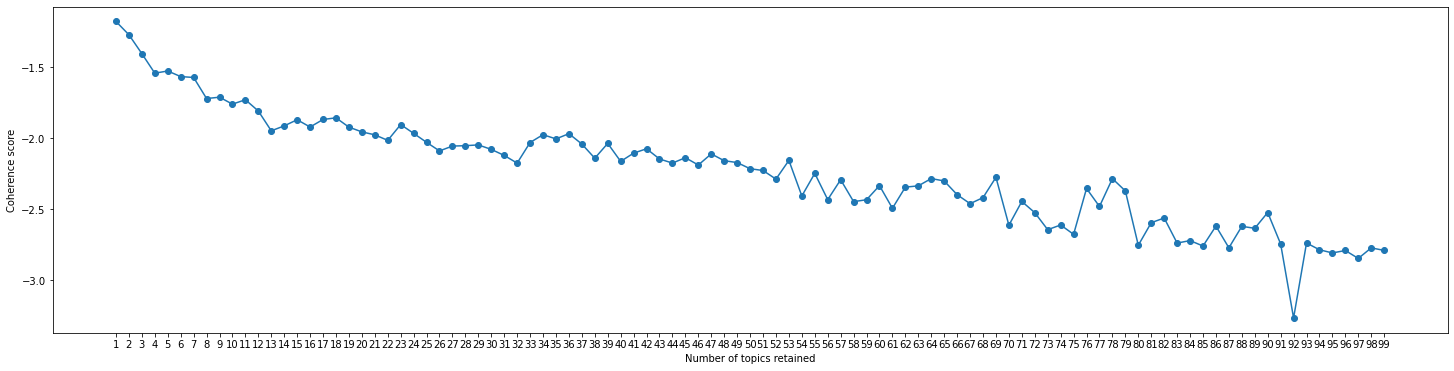

In [ ]:
# plot coherence scores
fig = plt.figure(figsize=(25, 6))
ax = fig.add_subplot(111)
# plt.plot(np.array(list(loss.values())).astype(float))
ax.plot(list(cvs.keys()), list(cvs.values()), "o-")
ax.set_xlabel("Number of topics retained")
ax.set_ylabel("Coherence score")
ax.set_xticks(range(1, 100, 1))
plt.show()

In [ ]:
topics_num = [15,16,17,18,19,20,21,22,23,24,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53]
# [13, 26,31,32] 
for i in topics_num:
  best_mdl = tp.LDAModel(k=i, corpus=corpus)
  for d in range(0, 100, 10):
      best_mdl.train(10)
      print("Iteration: {}\tLog-likelihood: {}".format(d, best_mdl.ll_per_word))
  # prepare data for visualization
  topic_term_dists = np.stack([best_mdl.get_topic_word_dist(k) for k in range(best_mdl.k)])
  doc_topic_dists = np.stack([doc.get_topic_dist() for doc in best_mdl.docs])
  doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
  doc_lengths = np.array([len(doc.words) for doc in best_mdl.docs])
  vocab = list(best_mdl.used_vocabs)
  term_frequency = best_mdl.used_vocab_freq

  # visualize the topics
  prepared_data = pyLDAvis.prepare(
      topic_term_dists, 
      doc_topic_dists, 
      doc_lengths, 
      vocab, 
      term_frequency,
      start_index=0, # tomotopy starts topic ids with 0, pyLDAvis with 1
      sort_topics=False # IMPORTANT: otherwise the topic_ids between pyLDAvis and tomotopy are not matching!
  )
  pyLDAvis.save_html(prepared_data, 'ldavis{}.html'.format(i))
  # # get summary of the best model
  # best_mdl.summary()

In [ ]:
# topic model estimation (try 7,8,9,12)
best_mdl = tp.LDAModel(k=6, corpus=corpus)
for i in range(0, 1000, 20):
    best_mdl.train(20)
    print("Iteration: {}\tLog-likelihood: {}".format(i, best_mdl.ll_per_word))
# get summary of the best model
best_mdl.summary()

In [ ]:
# prepare data for visualization
topic_term_dists = np.stack([best_mdl.get_topic_word_dist(k) for k in range(best_mdl.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in best_mdl.docs])
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
doc_lengths = np.array([len(doc.words) for doc in best_mdl.docs])
vocab = list(best_mdl.used_vocabs)
term_frequency = best_mdl.used_vocab_freq

# visualize the topics
prepared_data = pyLDAvis.prepare(
    topic_term_dists, 
    doc_topic_dists, 
    doc_lengths, 
    vocab, 
    term_frequency,
    start_index=0, # tomotopy starts topic ids with 0, pyLDAvis with 1
    sort_topics=False # IMPORTANT: otherwise the topic_ids between pyLDAvis and tomotopy are not matching!
)
pyLDAvis.save_html(prepared_data, 'ldavis.html')

In [ ]:
# visualise the topics
pyLDAvis.enable_notebook()
DATA_VIS = pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab,term_frequency)


In [ ]:
# word to topic probabilities
# an empty Pandas DF to populate
wt = pd.DataFrame()
# get word probabilities for each topic
for k in range(best_mdl.k):
    words, probs = [], []
    for word, prob in best_mdl.get_topic_words(k):
        words.append(word)
        probs.append(prob)
    tmp = pd.DataFrame(
        {
            "word": words,
            "prob": np.round(probs, 3),
            "k": np.repeat(k, len(words)),
            "sort": np.arange(0, len(words)),
        }
    )
    wt = pd.concat([wt, tmp], ignore_index=False)
    del tmp


# get topic probabilities for each document
td = pd.DataFrame(
    np.stack([doc.get_topic_dist() for doc in best_mdl.docs]),
    columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
)

### BOW

### Word Embedding

### TF-IDF & Ngrams

In [ ]:
def simple_logistic_classify(x_train, x_test,y_train, y_test):
    model = LogisticRegression(C=1.0).fit(x_train, y_train)
    score = model.score(x_test, y_test)
    return score


In [ ]:
# select n-gram
# train model with different n-gram ranges
for N in tqdm.tqdm(range(1,5)):
    vectorizer = TfidfVectorizer(ngram_range=(1,N), max_features=2600)#TODO make a loop to find out the best value2600
    tfidf_output = vectorizer.fit_transform(tokens_list)
    x = vectorizer.get_feature_names_out()
    # contact the result of tfidf and index
    df_tfidfvect = pd.DataFrame(data = tfidf_output.toarray(),columns = x)

    # train model and generate predictions
    # split indepedent variable train and validation set
    x_train, x_test = train_test_split(df_tfidfvect, test_size=0.3, random_state=42)
    # split dependent varaible 
    y_train, y_test = train_test_split(review_cat, test_size=0.3, random_state=42)

    # compute f-1 score
    model = simple_logistic_classify(x_train, x_test,y_train, y_test)
    print('F-1 score of model with n-gram range of {}: {}'.format((1,N),model))



In [ ]:
# final n-gram is 1-gram
vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=2600)#
tfidf_output = vectorizer.fit_transform(tokens_list)
x = vectorizer.get_feature_names_out()
# contact the result of tfidf and index
df_tfidfvect = pd.DataFrame(data = tfidf_output.toarray(),columns = x)

### SMOTE

### Length Analysis 

In [ ]:
# create a table for tokenised data
df_mdy_train = pd.DataFrame({'imbd_user_review':mdy_train,'helpfulness_cat':review_cat})

In [ ]:
# create column for length analysis outcome
df_mdy_train['word_count'] = df_mdy_train["imbd_user_review"].apply(lambda x: len(x))
df_mdy_train['char_count'] = df_mdy_train["imbd_user_review"].apply(lambda x: sum(len(word) for word in x))
df_mdy_train['sentence_count']  = review_text.apply(lambda x: len(str(x).split(".")))
df_mdy_train['avg_word_length'] = df_mdy_train['char_count'] / df_mdy_train['word_count']
df_mdy_train['avg_sentence_length'] = df_mdy_train['word_count'] / df_mdy_train['sentence_count']
df_mdy_train.head()

,imbd_user_review,helpfulness_cat,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
0,"[hard, delightful, adorable, movie, day, kid, ...",1.0,49,308,12,6.285714,4.083333
1,"[film, fade, haunt, masterpiece, silent, cinem...",1.0,151,902,20,5.973510,7.550000
2,"[view, movie, age, yrsprobably, movie, think, ...",1.0,18,113,5,6.277778,3.600000
3,"[doubt, resemble, complete, version, metropoli...",1.0,65,454,7,6.984615,9.285714
4,"[shocked, rivet, movie, doubt, scifi, movie, e...",1.0,42,252,6,6.000000,7.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


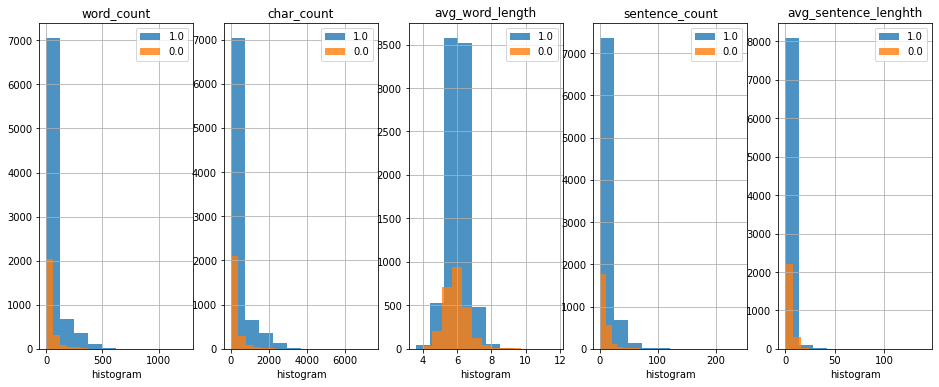

In [ ]:
# visualize the distribution of the dataset
import seaborn as sns
x1,x2,x3,x4,x5,y = "word_count","char_count","avg_word_length","sentence_count","avg_sentence_length", "helpfulness_cat"
fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(16,6))
for i in df_mdy_train[y].unique():
    sns.distplot(df_mdy_train[df_mdy_train[y]==i][x1], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(df_mdy_train[df_mdy_train[y]==i][x2], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[1])
    sns.distplot(df_mdy_train[df_mdy_train[y]==i][x3], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[2])
    sns.distplot(df_mdy_train[df_mdy_train[y]==i][x4], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[3])
    sns.distplot(df_mdy_train[df_mdy_train[y]==i][x5], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[4])
ax[0].grid(True)
ax[0].legend(df_mdy_train[y].unique())
ax[0].set_title("word_count")
ax[1].grid(True)
ax[1].legend(df_mdy_train[y].unique())
ax[1].set_title("char_count")
ax[2].grid(True)
ax[2].legend(df_mdy_train[y].unique())
ax[2].set_title("avg_word_length")
ax[3].grid(True)
ax[3].legend(df_mdy_train[y].unique())
ax[3].set_title("sentence_count")
ax[4].grid(True)
ax[4].legend(df_mdy_train[y].unique())
ax[4].set_title("avg_sentence_lenghth")
plt.show()

### Dimension Reduction

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# Use TSNE to reduce the demension to 2
TSNE_model = TSNE(n_components=3, random_state=0)
TSNE_result = TSNE_model.fit_transform(df_tfidfvect)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
TSNE_result_dfm = pd.DataFrame(TSNE_result, columns=['x', 'y','z'])
TSNE_result_dfm.head()

,x,y,z
0,35.296894,33.511894,-18.957975
1,43.665710,28.387058,6.490153
2,-3.823193,5.475380,-1.629816
3,20.880701,10.970266,-16.563936
4,27.041716,7.643130,-22.914478


### Combine features

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
df3.iloc[:,2600:2603] = scaler.fit_transform(df3.iloc[:,2600:2603])

In [ ]:
df3 = pd.concat([df_tfidfvect, df_mdy_train.iloc[:,1:4]],axis="columns")

In [ ]:
df3.head()

,abandon,ability,abrams,absolute,absolutely,absurd,abuse,academy,accent,accept,...,yesterday,york,young,youth,youtube,zombie,zone,word_count,char_count,avg_word_length
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034426,0.038186,0.309850
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109836,0.114971,0.282353
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010656,0.012407,0.321429
3,0.0,0.0,0.0,0.0,0.0,0.0,0.321394,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050820,0.061070,0.359944
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027869,0.029915,0.289916


### Logistic Regression

In [ ]:
# split indepedent variable train and validation set
x_train, x_test = train_test_split(df_tfidfvect, test_size=0.3, random_state=42)

In [ ]:
# split dependent varaible 
y_train, y_test = train_test_split(review_cat, test_size=0.3, random_state=42)

In [ ]:
def simple_logistic_classify(x_train, y_train, x_test, y_test, _C=1):
    model = LogisticRegression(C=_C).fit(x_train, y_train)
    score = model.score(x_test, y_test)
    print('Test Score is', score)
    return model

In [ ]:
model = simple_logistic_classify(x_train, y_train, x_test, y_test)

Test Score is 0.7709947319491788


In [ ]:
# hype-parameter tuning 
from sklearn.model_selection import GridSearchCV
import sklearn
param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}
# bow_search = sklearn.model_selection.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)
tfidf_search = sklearn.model_selection.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)

In [ ]:
# confusion matrix and classification report(precision, recall, F1-score)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(classification_report(y_test, model.predict(x_test)))
print(confusion_matrix(y_test, model.predict(x_test)))

              precision    recall  f1-score   support

         0.0       0.66      0.19      0.30       740
         1.0       0.80      0.97      0.88      2487

    accuracy                           0.79      3227
   macro avg       0.73      0.58      0.59      3227
weighted avg       0.77      0.79      0.75      3227

[[ 144  596]
 [  74 2413]]


### TensorFlow -GRU

In [ ]:
! pip install plotly.express

In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
#import plotly.express as px
#import plotly.figure_factory as ff

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

In [17]:
raw_data = pd.read_csv('train.csv')


In [18]:
raw_data.head()

,helpfulness_cat,imdb_user_review
0,1.0,It is hard to find such delightful and adorabl...
1,1.0,"They don't make films like this faded, hauntin..."
2,1.0,I first viewed this movie in 1924 at age 6 yrs...
3,1.0,I doubt that I'd ever seen anything resembling...
4,1.0,I was shocked to find myself riveted to this m...


In [19]:
raw_data['imdb_user_review'].apply(lambda x:len(str(x).split())).max()

3798

In [20]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [21]:
xtrain, xvalid, ytrain, yvalid = train_test_split(raw_data.imdb_user_review.values, raw_data.helpfulness_cat.values, 
                                                  stratify=raw_data.helpfulness_cat.values, 
                                                  random_state=42, 
                                                  test_size=0.3, shuffle=True)

In [7]:
# xvalid, xtest, yvalid, ytest = train_test_split(xvalid_test, yvalid_test, 
                                                  #stratify=yvalid_test, 
                                                  #random_state=42, 
                                                  #test_size=0.5, shuffle=True)

In [22]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 3798

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [ ]:
train_size, max_len, embed_size = X_train_emb.shape
X_train_emb_r = X_train_emb.reshape(train_size, max_len*embed_size)

In [28]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('/content/drive/MyDrive/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

0it [00:00, ?it/s]

Found 2196016 word vectors.


In [30]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

  0%|          | 0/50868 [00:00<?, ?it/s]

In [44]:
%%time
with strategy.scope():
    # GRU with glove embeddings and two dense layers
     model = Sequential()
     model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
     model.add(SpatialDropout1D(0.3))
     model.add(GRU(300))
     model.add(Dense(1, activation='sigmoid'))

     model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3798, 300)         15260700  
                                                                 
 spatial_dropout1d (SpatialD  (None, 3798, 300)        0         
 ropout1D)                                                       
                                                                 
 gru (GRU)                   (None, 300)               540900    
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 15,801,901
Trainable params: 541,201
Non-trainable params: 15,260,700
_________________________________________________________________
CPU times: user 752 ms, sys: 301 ms, total: 1.05 s
Wall time: 4.56 s


In [43]:
tf.keras.backend.clear_session()

In [ ]:
model.fit(xtrain_pad, ytrain, epochs=100, batch_size=64*strategy.num_replicas_in_sync)

In [46]:
scores = model.predict(xvalid_pad)
print("Auc: %.2f%%" % (roc_auc(scores,yvalid)))

Auc: 0.68%


### Bert

In [24]:
!pip install -U transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import transformers
from tqdm.notebook import tqdm
import tokenizers
from tokenizers import BertWordPieceTokenizer

In [ ]:
def clean_text(text):
    text = str(text)
    text = re.sub(r'[0-9"]', '', text) # number
    text = re.sub(r'#[\S]+\b', '', text) # hash
    text = re.sub(r'@[\S]+\b', '', text) # mention
    text = re.sub(r'https?\S+', '', text) # link
    text = re.sub(r'\s+', ' ', text) # multiple white spaces
#     text = re.sub(r'\W+', ' ', text) # non-alphanumeric
    return text.strip()

def text_process(text):
    ws = text.split(' ')
    if(len(ws)>160):
        text = ' '.join(ws[:160]) + ' ' + ' '.join(ws[-32:])
    return text

def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    print('encoding with', tokenizer)
    
    # for transformers 3.5
    if isinstance(tokenizer, transformers.DistilBertTokenizer) or \
        isinstance(tokenizer, transformers.DistilBertTokenizerFast):
    #     tokenizer.enable_truncation(max_length=maxlen)
    #     tokenizer.enable_padding(max_length=maxlen)
        all_ids = []

        for i in tqdm(range(0, len(texts), chunk_size)):
            text_chunk = texts[i:i+chunk_size].tolist()
    #         encs = tokenizer.encode_batch(text_chunk)
            encs = tokenizer(text_chunk, padding='max_length', truncation=True, max_length=maxlen)
    #         all_ids.extend([enc.ids for enc in encs])
            all_ids.extend(encs['input_ids']) 
    elif isinstance(fast_tokenizer, tokenizers.implementations.bert_wordpiece.BertWordPieceTokenizer): 
        tokenizer.enable_truncation(max_length=maxlen)
        tokenizer.enable_padding(max_length=maxlen)
        all_ids = []

        for i in tqdm(range(0, len(texts), chunk_size)):
            text_chunk = texts[i:i+chunk_size].tolist()
            encs = tokenizer.encode_batch(text_chunk)
            all_ids.extend([enc.ids for enc in encs])

    
    return np.array(all_ids)

In [ ]:
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizerFast.from_pretrained('distilbert-base-multilingual-cased')

save_path = '/kaggle/working/distilbert_base_cased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)
fast_tokenizer = tokenizer

# "faster as the tokenizers from transformers because they are implemented in Rust."
# fast_tokenizer = BertWordPieceTokenizer('distilbert_base_cased/vocab.txt', lowercase=False)

In [ ]:
# Configuration
AUTO = tf.data.experimental.AUTOTUNE
SHUFFLE = 2048
EPOCHS1 = 20
EPOCHS2 = 4
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192
VERBOSE = 2

In [ ]:
xtrain, xvalid, ytrain, yvalid = train_test_split(raw_data.imdb_user_review.values, raw_data.helpfulness_cat.values, 
                                                  stratify=raw_data.helpfulness_cat.values, 
                                                  random_state=42, 
                                                  test_size=0.3, shuffle=True)

In [ ]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")
valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')